In [1]:
import pandas as pd
from joblib import load
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])

2022-04-08 12:32:32.434179: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-08 12:32:32.434253: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
version = '9.0.5'
train = pd.read_csv(f'../data_files/{version}/train.csv', index_col=[0])
X_train = train.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_train = train.category

test = df = pd.read_csv(f'../data_files/{version}/test.csv', index_col=[0])
X_test = test.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_test = test.category

In [3]:
nn = tf.keras.models.load_model(f'../neural_network/models/v{version}')
knn = load(f'../classification_methods/models/KNN_{version}_tune.joblib')
rfc = load(f'../classification_methods/models/RFC_{version}_tune.joblib')
dtc = load(f'../classification_methods/models/DTC_{version}_tune.joblib')
xgb = load(f'../classification_methods/models/XGB_{version}.joblib')

models = {'NN': nn, 'KNN': knn, 'RFC': rfc, 'DTC': dtc, 'XGB': xgb}

2022-04-08 12:34:27.821856: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-08 12:34:27.828172: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-08 12:34:27.828229: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eprexb.ph.bham.ac.uk): /proc/driver/nvidia/version does not exist
2022-04-08 12:34:27.828901: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/user211/envs/scientific/lib64/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying t

## Generate Predictions

In [4]:
train_preds = {}
test_preds = {}

for name, model in models.items():
    try:
        train_preds[name] = model.predict_proba(X_train.to_numpy())[:,1]
        test_preds[name] = model.predict_proba(X_test.to_numpy())[:,1]
    except:
        train_preds[name] = model.predict(X_train.to_numpy()).flatten()
        test_preds[name] = model.predict(X_test.to_numpy()).flatten()

2022-04-08 12:35:05.119263: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


## Define Metrics

In [16]:
def display_scores(scores):
    for key, value in scores.items():
        print(f"Model: {key}\nTrain: {value[0]:.3f}\nTest: {value[1]:.3f}\n")
        
def get_f1_score(train_preds, test_preds, threshold):
    """
    Get the F1 score for a model or set of models. Values closer to
    one are better.
    
    Parameters
    ----------
    train_preds : dict
        A dictionary of model names and values are array like probabilties
        for an event to be signal.
    test_preds : dict
        The same as the above but for the test data
    thresholdl : float, array_like
        Either a float value for the cut threshold value as found by the
        Punzi FoM or an array of values to evaluate multiple F1 scores.
        
    Returns
    -------
    scores : dict
     A dictionary with keys the model names from the prior dictionary and keys
     are numpy arrays of scores at the threshold values passed. Shape is N x 2,
     sorted such that the 1st column are for training and the second for test data.
    """
    
    scores = {}
    if type(threshold) is float:
        threshold = np.array([threshold])
    for name, pred in train_preds.items():
        model_scores = []
        for thr in threshold:
            metric = tfa.metrics.F1Score(num_classes=1, threshold=thr)
            metric.update_state(np.array([[i] for i in y_train.to_numpy()]), np.array([[i] for i in pred]))
            train_f1 = metric.result()
            
            metric = tfa.metrics.F1Score(num_classes=1, threshold=thr)
            metric.update_state(np.array([[i] for i in y_test.to_numpy()]), np.array([[i] for i in test_preds[name]]))
            test_f1 = metric.result()
            model_scores.append([train_f1, test_f1])
        scores[name] = np.squeeze(np.array(model_scores))
    return scores

def get_accuracy_score(train_preds, test_preds, train_labels, test_labels, threshold):
    scores = {}
    for name, pred in train_preds.items():
        if type(threshold) is float:
            threshold = np.array([threshold])
        model_scores = []
        for thr in threshold:
            train_acc = accuracy_score(train_labels, np.where(pred > thr, 1, 0))
            test_acc = accuracy_score(test_labels, np.where(test_preds[name] > thr, 1, 0))
            model_scores.append([train_acc, test_acc])
        scores[name] = np.squeeze(np.array(model_scores))
    return scores

def get_purity_score(train_preds, test_preds, train_labels, test_labels, threshold):
    scores = {}
    for name, pred in train_preds.items():
        if type(threshold) is float:
            threshold = np.array([threshold])
        model_scores = []
        for thr in threshold:
            train_classes = np.where(pred > thr, 1, 0)
            test_classes = np.where(test_preds[name] > thr, 1, 0)
            train_purity = np.count_nonzero(np.logical_and(train_labels==1, train_classes==1)) / np.count_nonzero(train_classes)
            test_purity = np.count_nonzero(np.logical_and(test_labels==1, test_classes==1)) / np.count_nonzero(test_classes)
            model_scores.append([train_purity, test_purity])
        scores[name] = np.squeeze(np.array(model_scores))
    return scores

def get_roc_score(train_preds, test_preds, train_labels, test_labels, displayPlots=False, showTrain=False, showTest=True, savePlots=False):
    scores = {}
    for name, pred in train_preds.items():
        train_roc_score = roc_auc_score(train_labels, pred)
        test_roc_score = roc_auc_score(test_labels, test_preds[name])
        scores[name] = np.squeeze(np.array([train_roc_score, test_roc_score]))
    if displayPlots:
        fig, ax = plt.subplots(1, 1)
        for name, score in scores.items():
            train_roc = roc_curve(train_labels, train_preds[name])
            test_roc = roc_curve(test_labels, test_preds[name])
            best_train_pos = np.argmin(np.sqrt((1-train_roc[1])**2 + (train_roc[0])**2))
            best_test_pos = np.argmin(np.sqrt((1-test_roc[1])**2 + (test_roc[0])**2))
            print(f"{name} best pos: ({train_roc[1][best_train_pos]:.3f}, {(1-train_roc[0])[best_train_pos]:3f})")
            print(f"{name} best pos: ({test_roc[1][best_test_pos]:.3f}, {(1-test_roc[0])[best_test_pos]:3f})")
            if showTrain:
                ax.plot(train_roc[1], 1-train_roc[0], label=f'{name} train {score[0]:.3f}')
            if showTest:
                ax.plot(test_roc[1], 1-test_roc[0], label=f'{name} ({score[1]:.3f})')
        ax.legend()
        ax.set_xlim(0.7, 1)
        ax.set_ylim(0.7, 1)
        plt.xlabel('Signal Selection Rate')
        plt.ylabel('Background Rejection Rate')
        plt.tight_layout()
        if savePlots:
            plt.savefig(f'../images/ModelEval/{version}_roc_curves.png')
        plt.show()
    return scores

def get_ks_score(train_preds, test_preds, displayPlots=False, showTestOnly=False, savePlots=False, plotModels=['NN', 'KNN', 'XGB', 'RFC', 'DTC'],):
    scores = {}
    for name, pred in train_preds.items():
        ks, pvalue = ks_2samp(pred, test_preds[name])
        scores[name] = (ks, pvalue)
    if displayPlots:
        fig, ax = plt.subplots(1, 1)
        bins = np.linspace(0, 1, 51)
        for name, pred in train_preds.items():
            if name in plotModels:
                if showTestOnly:
                    ht, _ = np.histogram(test_preds[name], bins=bins)
                    hep.histplot(ht, yerr=True, bins=bins, ax=ax, label=name)
                else:
                    h, _ = np.histogram(pred, bins=bins, density=True)
                    h1, _ = np.histogram(test_preds[name], bins=bins, density=True)
                    hep.histplot([h, h1], yerr=False, bins=bins, ax=ax, label=[f'{name} train', f'{name} test'])
        plt.legend(loc='upper center')
        plt.xlabel('Predicted Probability')
        plt.ylabel('Candidates')
        plt.tight_layout()
        if savePlots:
            print('Zoom')
            plt.savefig('../images/ModelEval/TestProbDistRare.png')
        plt.show()
    return scores

Zoom


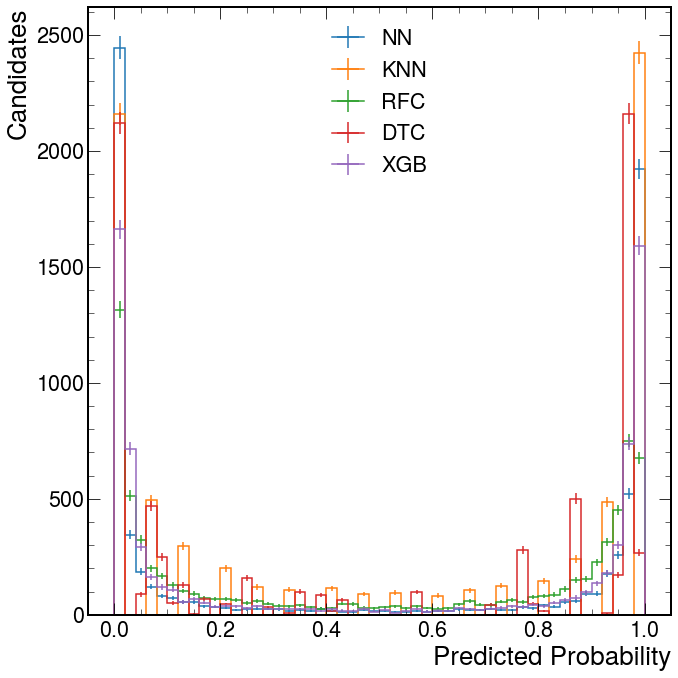

In [17]:
a = get_ks_score(train_preds, test_preds, displayPlots=True, showTestOnly=True, savePlots=True)

In [124]:
display_scores(a)

Model: NN
Train: 0.011
Test: 0.349

Model: KNN
Train: 0.012
Test: 0.230

Model: RFC
Train: 0.017
Test: 0.020

Model: DTC
Train: 0.010
Test: 0.459

Model: XGB
Train: 0.009
Test: 0.587

